# Social Doors Representational Similarity Analysis

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask
from nltools.stats import fdr, threshold, fisher_r_to_z, one_sample_permutation
from sklearn.metrics import pairwise_distances
from nilearn.plotting import plot_glass_brain, plot_stat_map

In [2]:
bids_dir = '/data/projects/social_doors/'
os.chdir(bids_dir)

outp_dir = os.path.join(bids_dir, 'derivatives', 'rsa')
data_dir = os.path.join(bids_dir, 'derivatives','social_doors')

if os.path.exists(outp_dir):
    print('Output directory already exists. Continuing will overwrite data.')
else:
    os.makedirs(outp_dir)

Output directory already exists. Continuing will overwrite data.


In [3]:
subjs_scan_info = pd.read_csv(bids_dir+'derivatives/participants_good.tsv', sep='\t')

subjs_list = list(subjs_scan_info['participant_id'].unique())
len(subjs_list)

subjs_list.sort()
print('Found '+str(len(subjs_list))+' subjects')
subj = subjs_list[0]

file_list = glob.glob(os.path.join(data_dir, subj, f'beta*.nii.gz'))
file_list.sort()
#file_list = file_list[:-2]
print('Found '+str(len(file_list))+' beta maps')

#conditions = [os.path.basename(x)[:-7].split('beta_')[-1] for x in file_list]

#beta = Brain_Data(file_list)

Found 63 subjects
Found 12 beta maps


In [4]:
print(subjs_list)

['sub-010', 'sub-013', 'sub-028', 'sub-036', 'sub-3845', 'sub-3846', 'sub-3848', 'sub-3849', 'sub-3852', 'sub-3855', 'sub-3864', 'sub-3865', 'sub-3874', 'sub-3880', 'sub-3883', 'sub-3886', 'sub-3887', 'sub-3890', 'sub-3892', 'sub-3893', 'sub-3895', 'sub-3912', 'sub-3920', 'sub-3967', 'sub-3989', 'sub-4011', 'sub-4017', 'sub-4018', 'sub-4019', 'sub-4020', 'sub-4069', 'sub-5049', 'sub-5051', 'sub-5054', 'sub-5058', 'sub-5064', 'sub-5067', 'sub-5068', 'sub-5082', 'sub-5083', 'sub-5084', 'sub-5085', 'sub-5090', 'sub-5091', 'sub-5092', 'sub-5093', 'sub-5094', 'sub-5095', 'sub-5098', 'sub-5102', 'sub-5108', 'sub-5125', 'sub-5126', 'sub-5130', 'sub-5131', 'sub-5133', 'sub-5136', 'sub-5140', 'sub-5145', 'sub-6003', 'sub-6004', 'sub-6005', 'sub-6006']


In [5]:
subjs_scan_info


,Unnamed: 0,participant_id,age,sex,group
0,0,sub-010,13,F,kid
1,2,sub-013,13,M,kid
2,5,sub-028,15,M,kid
3,6,sub-036,16,F,kid
4,7,sub-5049,12,F,kid
...,...,...,...,...,...
58,76,sub-4069,22,F,college
59,77,sub-6003,23,M,college
60,78,sub-6004,19,M,college
61,79,sub-6005,21,F,college


In [6]:
conditions = ['negative','negative_win','negative_loss',
             'positive','positive_win','positive_loss']

# Hypothesis RDMs

## Localization of monterary and social reward processing
### Hypothesis
The cerebellum will process monetary and social reward processing in separate regions within the cerebellum. These regions will be sensitive to teh valence of each domain.

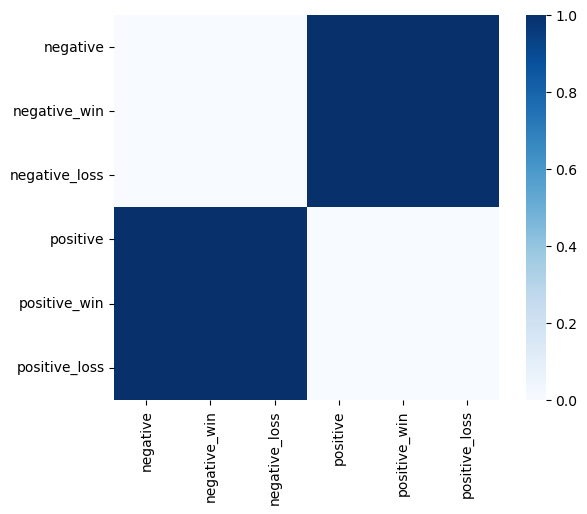

In [7]:
valence_df = pd.DataFrame([[0,0,0,1,1,1],
                          [0,0,0,1,1,1],
                          [0,0,0,1,1,1],
                          [1,1,1,0,0,0],
                          [1,1,1,0,0,0],
                          [1,1,1,0,0,0]],
                         index=conditions, columns=conditions)

valence_adj = Adjacency(valence_df, matrix_type='distance', labels=conditions)
f = valence_adj.plot(cmap=sns.color_palette("Blues", as_cmap=True))

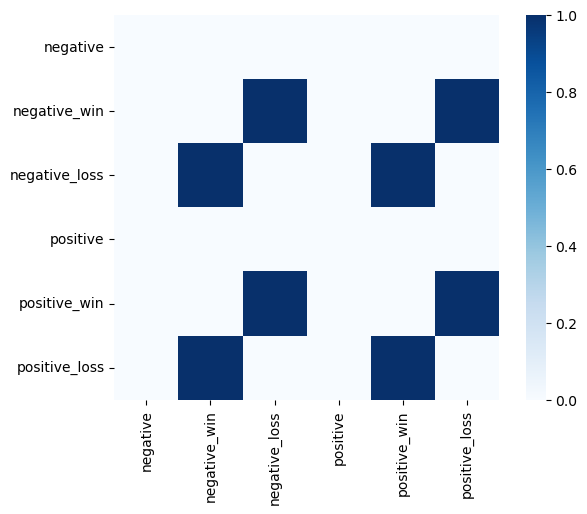

In [8]:
correct_df = pd.DataFrame([[0,0,0,0,0,0],
                          [0,0,1,0,0,1],
                          [0,1,0,0,1,0],
                          [0,0,0,0,0,0],
                          [0,0,1,0,0,1],
                          [0,1,0,0,1,0]],
                         index=conditions, columns=conditions)

correct_adj = Adjacency(correct_df, matrix_type='distance', labels=conditions)
f = correct_adj.plot(cmap=sns.color_palette("Blues", as_cmap=True))

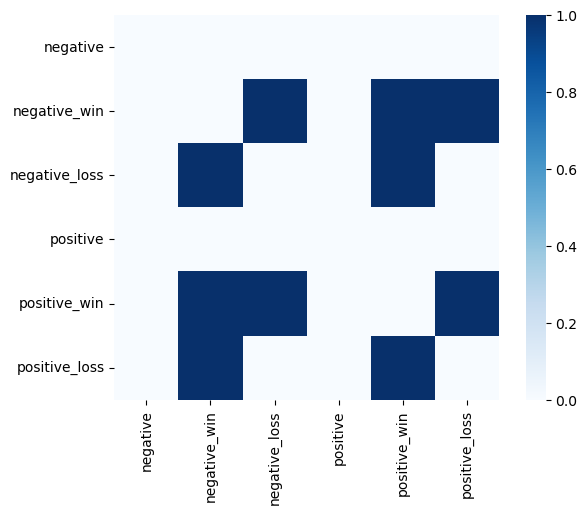

In [9]:
crctval_df = pd.DataFrame([[0,0,0,0,0,0],
                          [0,1,1,0,1,1],
                          [0,1,0,0,1,0],
                          [0,0,0,0,0,0],
                          [0,1,1,0,1,1],
                          [0,1,0,0,1,0]],
                         index=conditions, columns=conditions)

crctval_adj = Adjacency(crctval_df, matrix_type='distance', labels=conditions)
f = crctval_adj.plot(cmap=sns.color_palette("Blues", as_cmap=True))

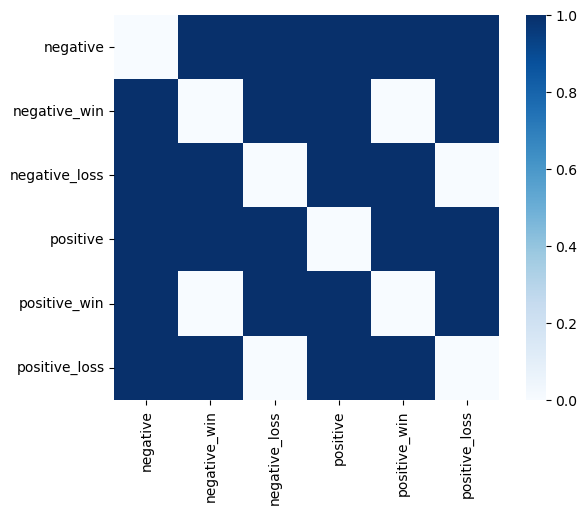

In [10]:
crctexc_df = pd.DataFrame([[0,1,1,1,1,1],
                          [1,0,1,1,0,1],
                          [1,1,0,1,1,0],
                          [1,1,1,0,1,1],
                          [1,0,1,1,0,1],
                          [1,1,0,1,1,0]],
                         index=conditions, columns=conditions)

crctexc_adj = Adjacency(crctexc_df, matrix_type='distance', labels=conditions)
f = crctexc_adj.plot(cmap=sns.color_palette("Blues", as_cmap=True))

# Reward Processing

In [11]:
# Import ROIs
reward_roi_list = glob.glob(os.path.join(bids_dir,'derivatives','rois', f'roi_bin_reward_*.nii.gz'))
reward_roi_names = [os.path.basename(x)[:-7].split('roi_bin_reward_')[-1] for x in reward_roi_list]

reward_roi_dict = dict(zip(reward_roi_names, reward_roi_list))


print(reward_roi_dict)


{'VS_l': '/data/projects/social_doors/derivatives/rois/roi_bin_reward_VS_l.nii.gz', 'VS_r': '/data/projects/social_doors/derivatives/rois/roi_bin_reward_VS_r.nii.gz', 'vmPFC_b': '/data/projects/social_doors/derivatives/rois/roi_bin_reward_vmPFC_b.nii.gz'}


/opt/anaconda3/lib/python3.7/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


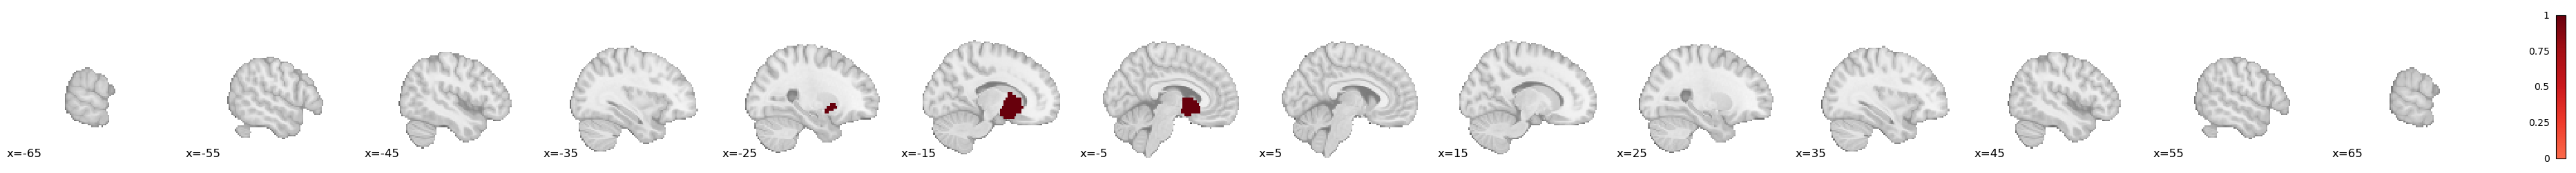

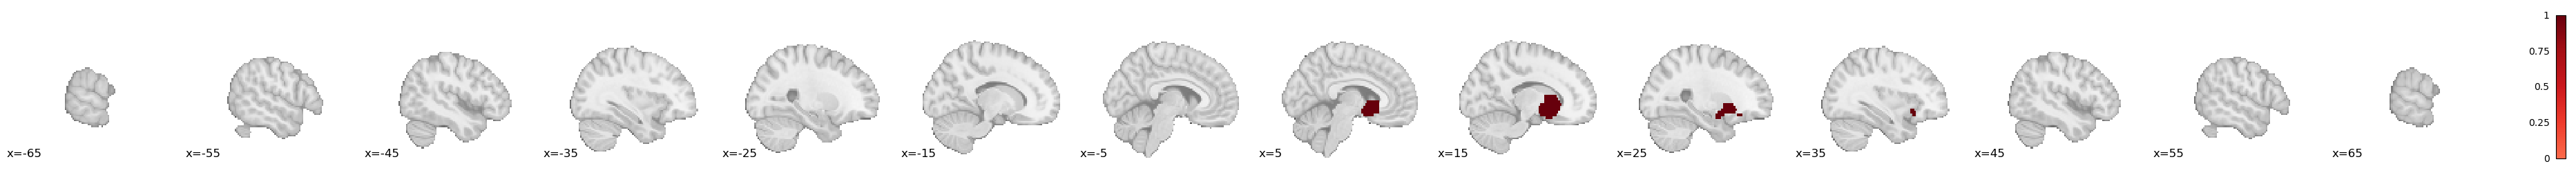

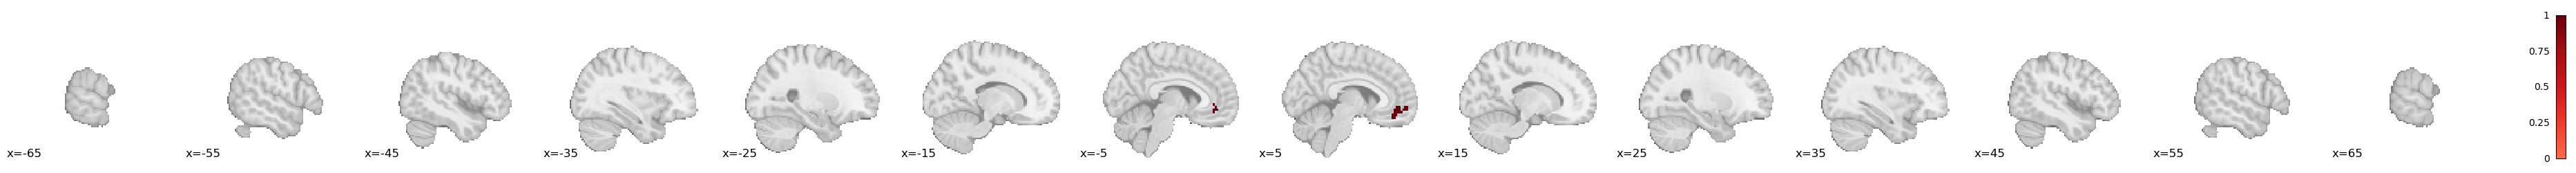

In [12]:
# Import ROIs
for n in range(len(reward_roi_names)):
    temp_roi = Brain_Data(reward_roi_list[n], mask=reward_roi_list[n])
    
    plot_stat_map(temp_roi.to_nifti(), 
                 cut_coords=range(-65,66,10), display_mode='x',
                 cmap='Reds')

In [13]:
# Import ROIs
rlearn_roi_list = glob.glob(os.path.join(bids_dir,'derivatives','rois', f'roi_bin_reinforcement-learning_*.nii.gz'))
rlearn_roi_names = [os.path.basename(x)[:-7].split('roi_bin_reinforcement-learning_')[-1] for x in rlearn_roi_list]

rlearn_roi_dict = dict(zip(rlearn_roi_names, rlearn_roi_list))


print(rlearn_roi_dict)

{'C1_r': '/data/projects/social_doors/derivatives/rois/roi_bin_reinforcement-learning_C1_r.nii.gz', 'VS_l': '/data/projects/social_doors/derivatives/rois/roi_bin_reinforcement-learning_VS_l.nii.gz', 'VS_r': '/data/projects/social_doors/derivatives/rois/roi_bin_reinforcement-learning_VS_r.nii.gz', 'LIX_r': '/data/projects/social_doors/derivatives/rois/roi_bin_reinforcement-learning_LIX_r.nii.gz', 'vmPFC_r': '/data/projects/social_doors/derivatives/rois/roi_bin_reinforcement-learning_vmPFC_r.nii.gz'}


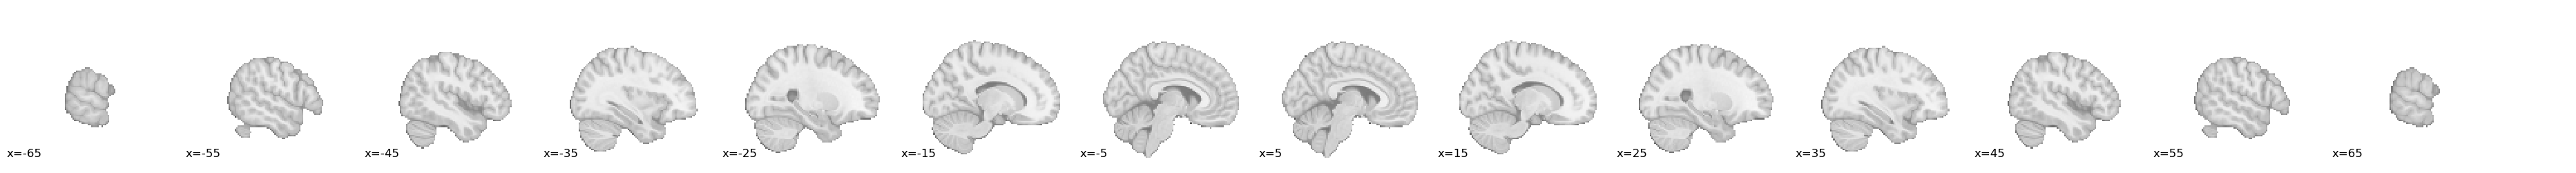

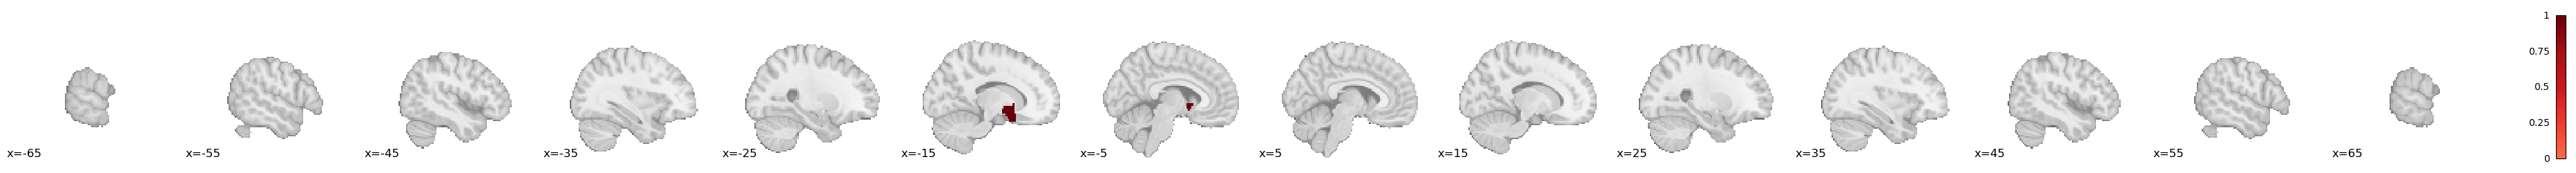

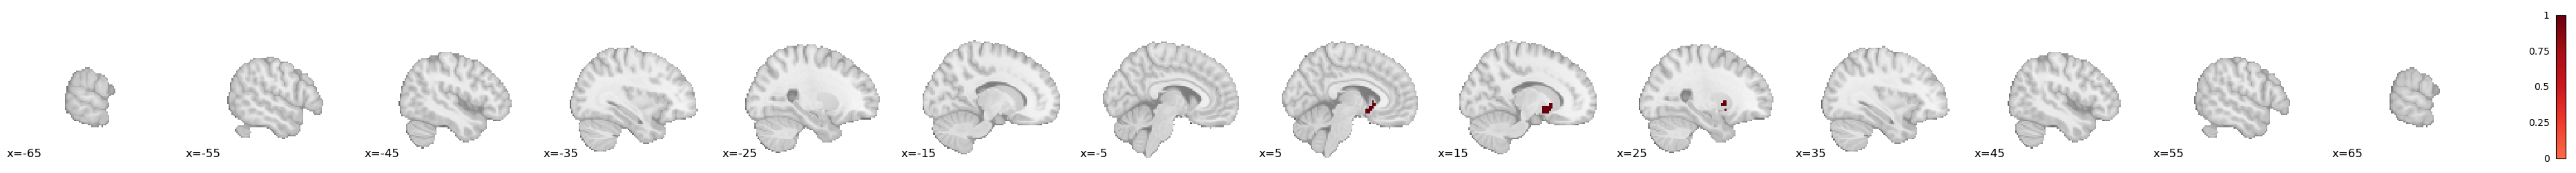

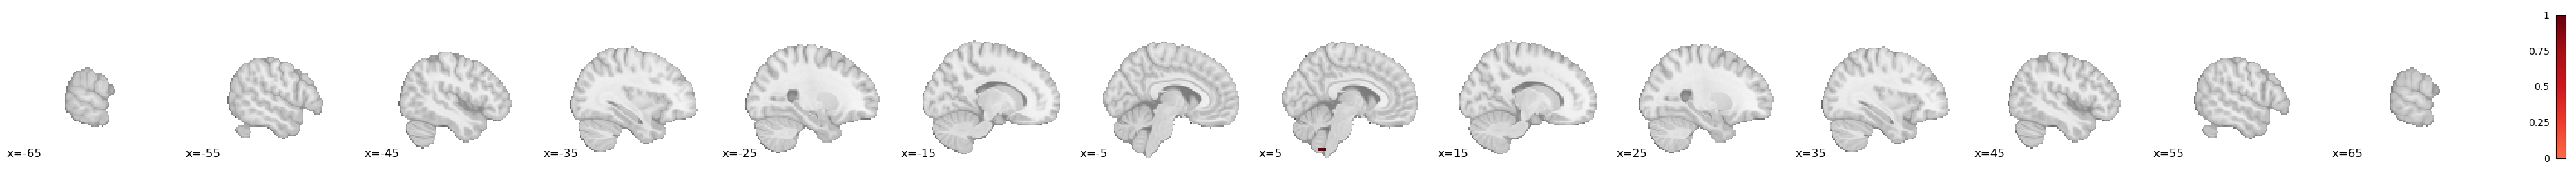

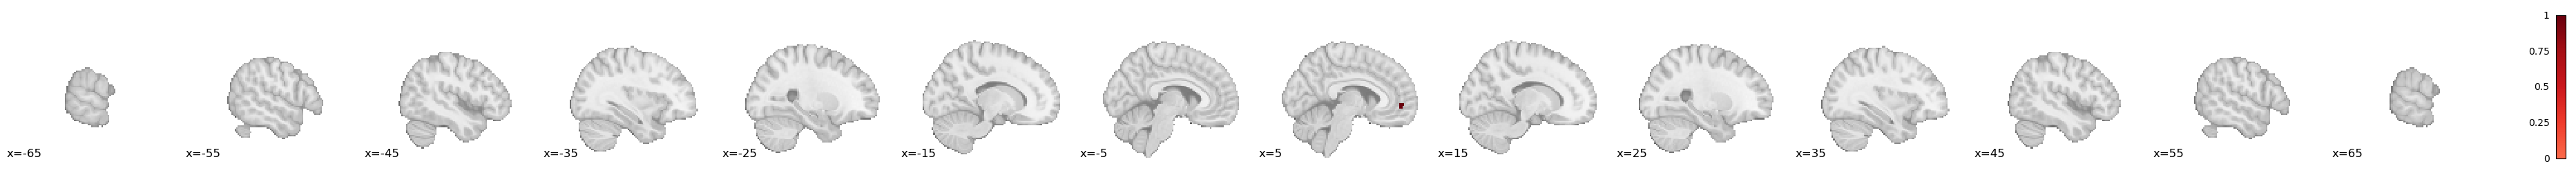

In [14]:
# Import ROIs
for n in range(len(rlearn_roi_names)):
    temp_roi = Brain_Data(rlearn_roi_list[n], mask=rlearn_roi_list[n])
    
    plot_stat_map(temp_roi.to_nifti(), 
                 cut_coords=range(-65,66,10), display_mode='x',
                 cmap='Reds')

In [15]:
# Import ROIs
social_roi_list = glob.glob(os.path.join(bids_dir,'derivatives','rois', f'roi_bin_social_*.nii.gz'))
social_roi_names = [os.path.basename(x)[:-7].split('roi_bin_social_')[-1] for x in social_roi_list]

social_roi_dict = dict(zip(social_roi_names, social_roi_list))


print(social_roi_dict)

{'ATL_r': '/data/projects/social_doors/derivatives/rois/roi_bin_social_ATL_r.nii.gz', 'TPJ_r': '/data/projects/social_doors/derivatives/rois/roi_bin_social_TPJ_r.nii.gz', 'ATL_l': '/data/projects/social_doors/derivatives/rois/roi_bin_social_ATL_l.nii.gz', 'TPJ_l': '/data/projects/social_doors/derivatives/rois/roi_bin_social_TPJ_l.nii.gz', 'C1_r': '/data/projects/social_doors/derivatives/rois/roi_bin_social_C1_r.nii.gz', 'dmPFC_b': '/data/projects/social_doors/derivatives/rois/roi_bin_social_dmPFC_b.nii.gz', 'AMG_r': '/data/projects/social_doors/derivatives/rois/roi_bin_social_AMG_r.nii.gz', 'PCC_b': '/data/projects/social_doors/derivatives/rois/roi_bin_social_PCC_b.nii.gz'}


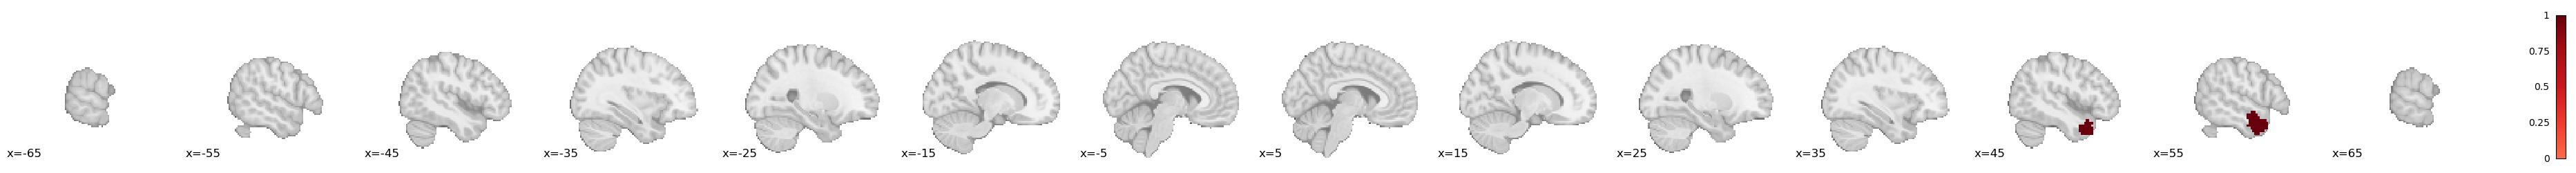

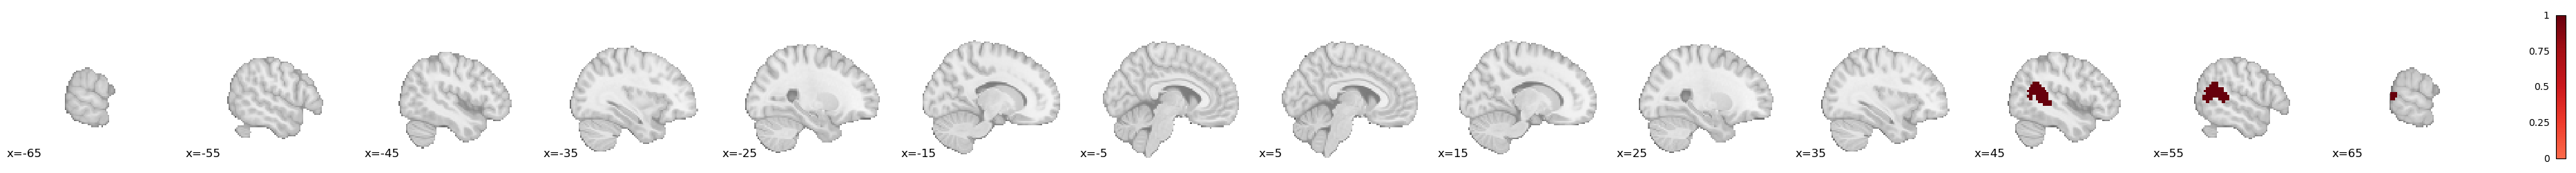

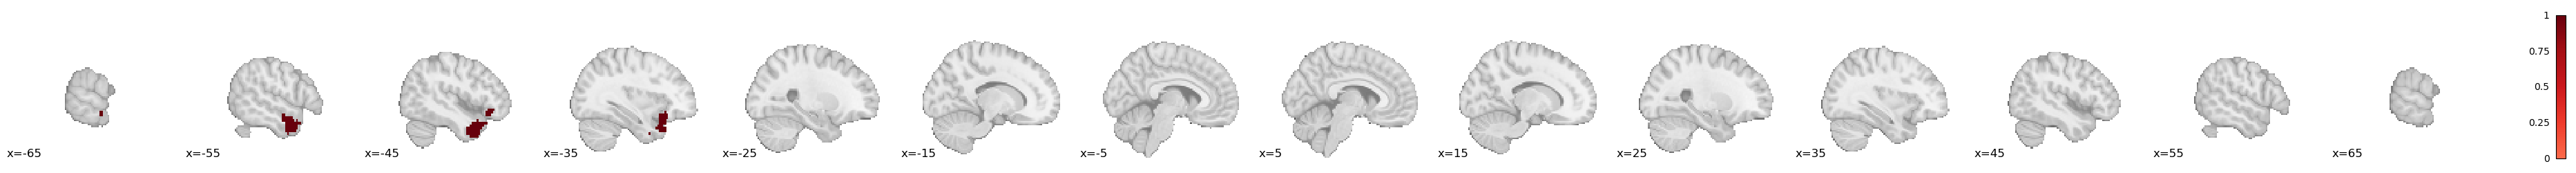

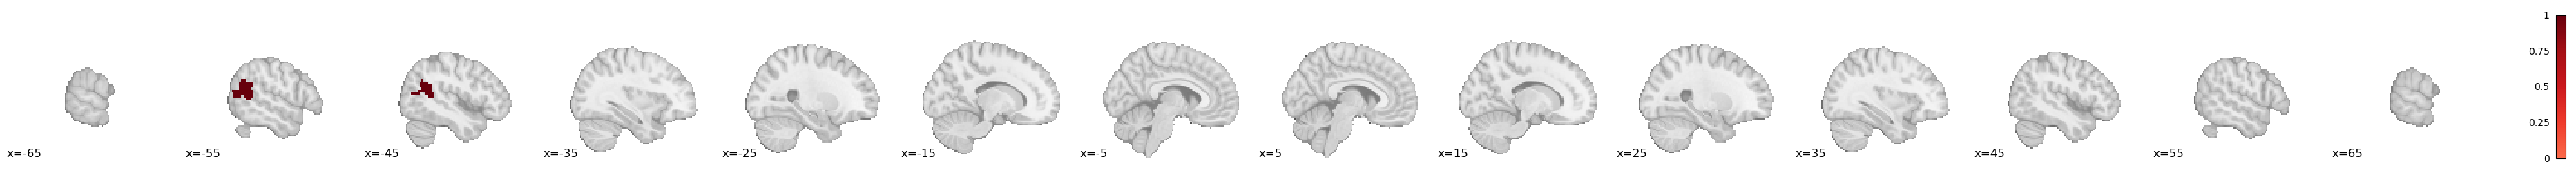

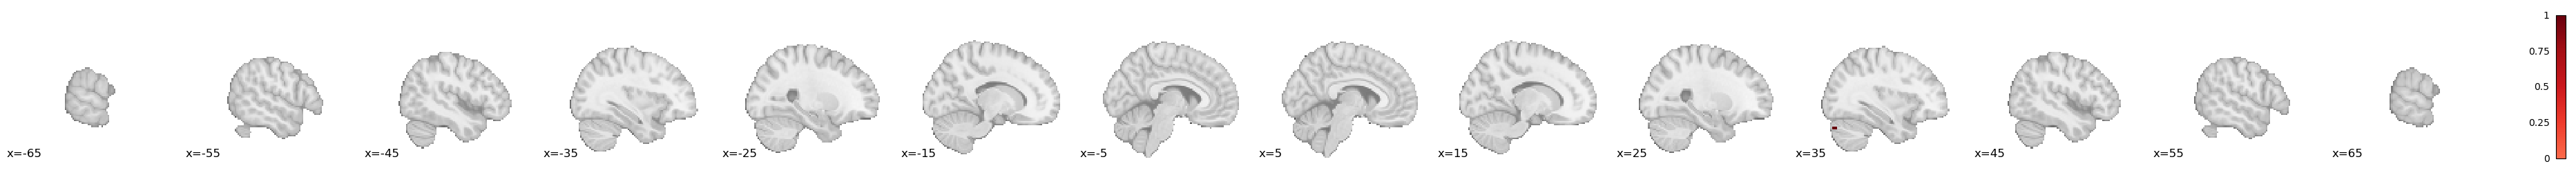

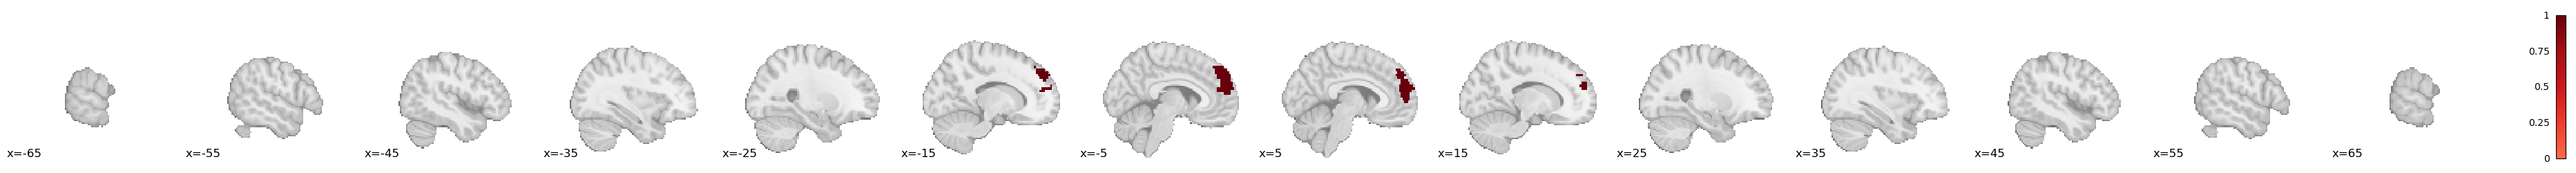

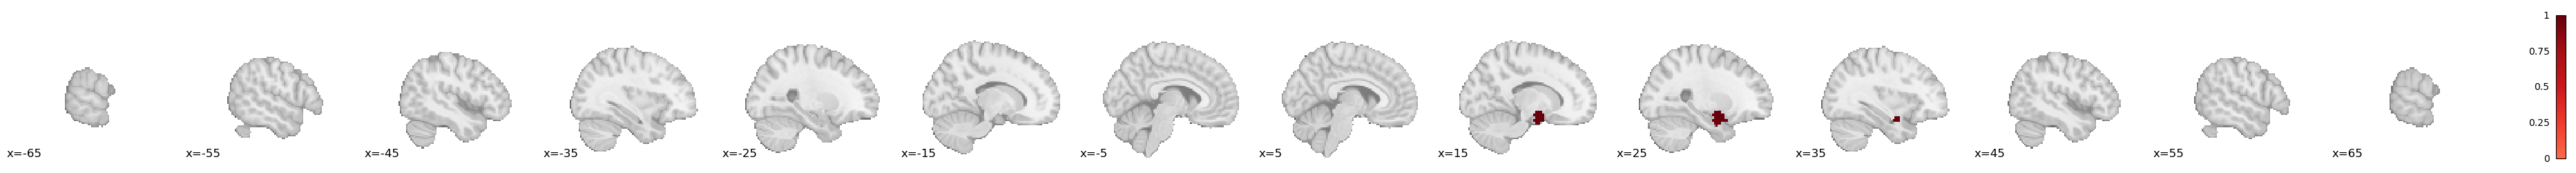

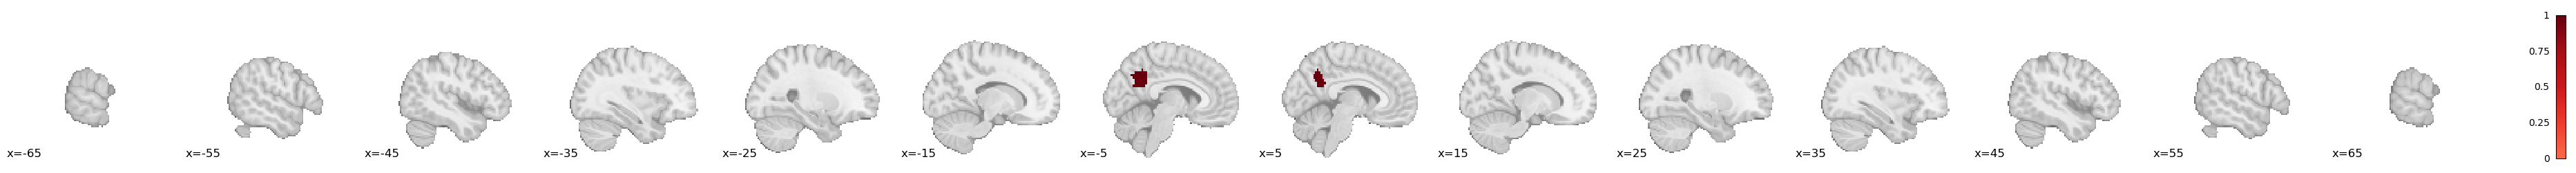

In [16]:
# Import ROIs
for n in range(len(social_roi_names)):
    temp_roi = Brain_Data(social_roi_list[n], mask=social_roi_list[n])
    
    plot_stat_map(temp_roi.to_nifti(), 
                 cut_coords=range(-65,66,10), display_mode='x',
                 cmap='Reds')

## Hypothesis
**The vmPFC will be sensitive to the valence of trials**

In [17]:
task = 'social'

subj_t1 = bids_dir+"derivatives/fmriprep/"+subj+"/func/"+subj+"_task-"+task+"_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"

func_files = [x for x in file_list if 'beta_'+task in x]
func_files.sort()
func_files


['/data/projects/social_doors/derivatives/social_doors/sub-010/beta_social_negative.nii.gz',
 '/data/projects/social_doors/derivatives/social_doors/sub-010/beta_social_negative_loss.nii.gz',
 '/data/projects/social_doors/derivatives/social_doors/sub-010/beta_social_negative_win.nii.gz',
 '/data/projects/social_doors/derivatives/social_doors/sub-010/beta_social_positive.nii.gz',
 '/data/projects/social_doors/derivatives/social_doors/sub-010/beta_social_positive_loss.nii.gz',
 '/data/projects/social_doors/derivatives/social_doors/sub-010/beta_social_positive_win.nii.gz']

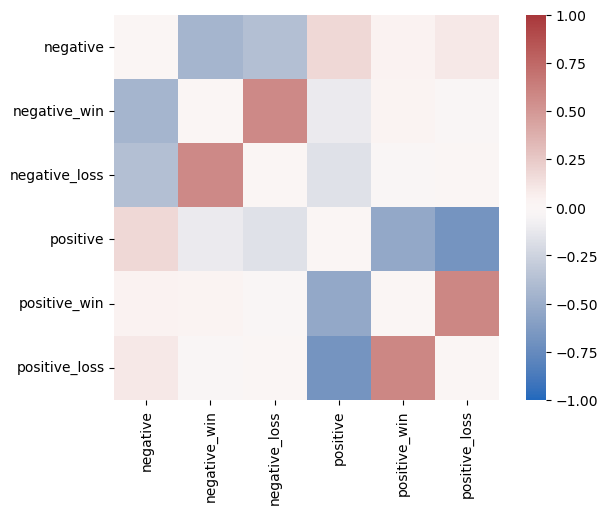

In [18]:
betas = Brain_Data(func_files, mask=subj_t1)

vmPFC_b_mask = Brain_Data(reward_roi_dict['vmPFC_b'], mask=subj_t1)

out = 1 - betas.apply_mask(vmPFC_b_mask).distance(metric='correlation')
out.labels=conditions

f2 = out.plot(vmin=-1, vmax=1, cmap=sns.color_palette('vlag', as_cmap=True))

In [19]:
out.similarity(valence_adj, metric='spearman', n_permute=0)

{'correlation': 0.2834733547569204, 'p': 1.0}

In [20]:
#all_sub_sim_adole = {}
all_sub_val_rsa = pd.DataFrame(columns=['subj','group','task','roi','r'])
all_sub_cor_rsa = pd.DataFrame(columns=['subj','group','task','roi','r'])
all_sub_cex_rsa = pd.DataFrame(columns=['subj','group','task','roi','r'])

rois = list(rlearn_roi_dict.values()) + list(social_roi_dict.values())
roi_names = [x + '-rlearn' for x in rlearn_roi_names] + [x + '-social' for x in social_roi_names]

for subj in subjs_list:
    file_list = glob.glob(os.path.join(data_dir, subj, f'tmap*.nii.gz'))
    file_list.sort()
    
    group_id = subjs_scan_info[subjs_scan_info['participant_id'] == subj]['group'].iloc[0]
    
    print('Calculating similarities for '+subj)
    
    for task in ['mdoors', 'social']:
        subj_t1 = bids_dir+"derivatives/fmriprep/"+subj+"/func/"+subj+"_task-"+task+"_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"

        func_files = [x for x in file_list if 'tmap_'+task in x]
        func_files = [x for x in func_files if 'V' not in x]
        func_files.sort()

        if len(func_files) < 6:
            continue
        else:

            betas = Brain_Data(func_files, mask=subj_t1)

            for n in range(len(rois)):
                temp_mask = Brain_Data(rois[n], mask=subj_t1)

                if betas.apply_mask(temp_mask).data.shape[1] == 0:
                    continue
                else:

                    sub_pattern_sim = betas.apply_mask(temp_mask).distance(metric='correlation')
                    sub_pattern_sim.labels = conditions


                    s_val = sub_pattern_sim.similarity(valence_adj, metric='spearman', n_permute=0)
                    s_cor = sub_pattern_sim.similarity(correct_adj, metric='spearman', n_permute=0)
                    s_cex = sub_pattern_sim.similarity(crctexc_adj, metric='spearman', n_permute=0)


                    #all_sub_sim[subj] = s_hyp1['correlation']
                    all_sub_val_rsa = all_sub_val_rsa.append({'subj':subj, 'group':group_id,
                                                                          'task':task,
                                                                          'roi':roi_names[n],
                                                                          'r':s_val['correlation']},
                                                                        ignore_index=True)
                    all_sub_cor_rsa = all_sub_cor_rsa.append({'subj':subj, 'group':group_id,
                                                                          'task':task,
                                                                          'roi':roi_names[n],
                                                                          'r':s_cor['correlation']},
                                                                        ignore_index=True)
                    all_sub_cex_rsa = all_sub_cex_rsa.append({'subj':subj, 'group':group_id,
                                                                          'task':task,
                                                                          'roi':roi_names[n],
                                                                          'r':s_cex['correlation']},
                                                                        ignore_index=True)

    
    
#all_sub_hyp1_rsa_adole = pd.DataFrame(all_sub_hyp1_rsa_adole, index=['r','roi']).T

Calculating similarities for sub-010
Calculating similarities for sub-013
Calculating similarities for sub-028
Calculating similarities for sub-036
Calculating similarities for sub-3845
Calculating similarities for sub-3846
Calculating similarities for sub-3848
Calculating similarities for sub-3849
Calculating similarities for sub-3852
Calculating similarities for sub-3855
Calculating similarities for sub-3864
Calculating similarities for sub-3865
Calculating similarities for sub-3874
Calculating similarities for sub-3880
Calculating similarities for sub-3883
Calculating similarities for sub-3886
Calculating similarities for sub-3887
Calculating similarities for sub-3890
Calculating similarities for sub-3892
Calculating similarities for sub-3893
Calculating similarities for sub-3895
Calculating similarities for sub-3912
Calculating similarities for sub-3920
Calculating similarities for sub-3967
Calculating similarities for sub-3989
Calculating similarities for sub-4011
Calculating simi

<AxesSubplot:xlabel='roi', ylabel='r'>

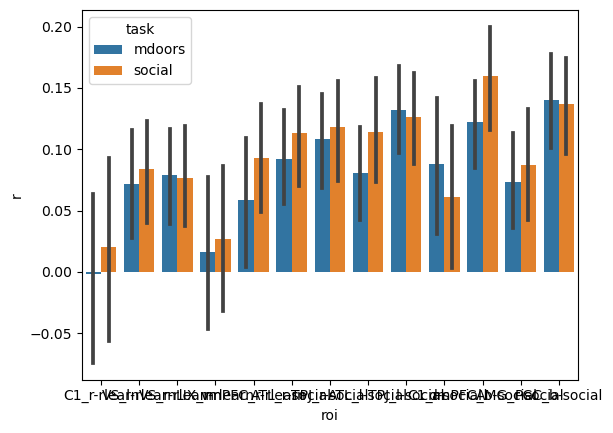

In [21]:
sns.barplot(x='roi',y='r',hue='task', data=all_sub_cex_rsa)
#sns.stripplot(x='roi',y='r',hue='task', data=all_sub_val_rsa)

<AxesSubplot:xlabel='roi', ylabel='r'>

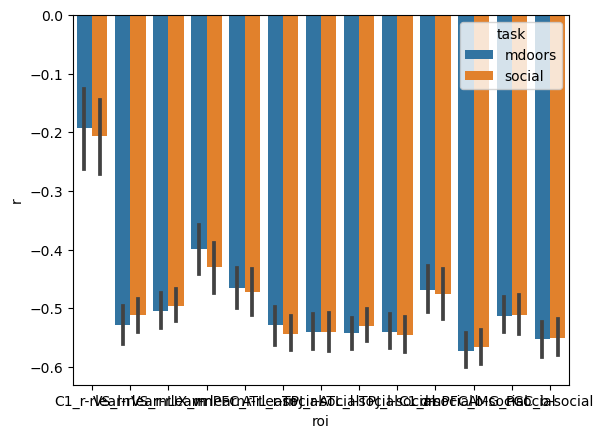

In [22]:
sns.barplot(x='roi',y='r',hue='task', data=all_sub_cor_rsa)
#sns.stripplot(x='roi',y='r',hue='task', data=all_sub_cor_rsa_adole)

## Individual condition pattern analysis

In [23]:
all_sub_sim_val_win = pd.DataFrame(columns=['subj','group','task','roi','r'])

rois = list(rlearn_roi_dict.values()) + list(social_roi_dict.values())
roi_names = [x + '-rlearn' for x in rlearn_roi_names] + [x + '-social' for x in social_roi_names]

#for roi in roi_names:
#    all_sub_sim[roi] = Brain_Data(mask=subj_t1)

for subj in subjs_list:
    file_list = glob.glob(os.path.join(data_dir, subj, f'tmap*.nii.gz'))
    file_list.sort()
    
    group_id = subjs_scan_info[subjs_scan_info['participant_id'] == subj]['group'].iloc[0]
    
    print('Calculating similarities for '+subj)
    
    for task in ['mdoors','social']:
    
        subj_t1 = bids_dir+"derivatives/fmriprep/"+subj+"/anat/"+subj+"_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz"

        func_files = [x for x in file_list if 'tmap_'+task in x]
        func_files = [x for x in func_files if 'V' not in x]
        func_files.sort()

        if len(func_files) < 6:
            continue
        else:

            pos_win_file = [x for x in func_files if 'positive_win' in x][0]
            neg_win_file = [x for x in func_files if 'negative_win' in x][0]

            beta_pos_win = Brain_Data(pos_win_file, mask=subj_t1)
            beta_neg_win = Brain_Data(neg_win_file, mask=subj_t1)

            for n in range(len(rois)):
                temp_mask = Brain_Data(rois[n], mask=subj_t1)

                if beta_pos_win.apply_mask(temp_mask).data.shape[0] == 0:
                    continue
                else:
                    sub_pattern_pos_win = beta_pos_win.apply_mask(temp_mask).data
                    sub_pattern_neg_win = beta_neg_win.apply_mask(temp_mask).data

                    temp_corr = np.corrcoef(sub_pattern_pos_win, sub_pattern_neg_win)[1][0]


                    all_sub_sim_val_win = all_sub_sim_val_win.append({'subj':subj, 'group':group_id,
                                                                          'task':task,
                                                                          'roi':roi_names[n],
                                                                          'r':temp_corr},
                                                                          ignore_index=True)


                

Calculating similarities for sub-010


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Calculating similarities for sub-013
Calculating similarities for sub-028
Calculating similarities for sub-036
Calculating similarities for sub-3845
Calculating similarities for sub-3846
Calculating similarities for sub-3848
Calculating similarities for sub-3849
Calculating similarities for sub-3852
Calculating similarities for sub-3855
Calculating similarities for sub-3864
Calculating similarities for sub-3865
Calculating similarities for sub-3874
Calculating similarities for sub-3880
Calculating similarities for sub-3883
Calculating similarities for sub-3886
Calculating similarities for sub-3887
Calculating similarities for sub-3890
Calculating similarities for sub-3892
Calculating similarities for sub-3893
Calculating similarities for sub-3895
Calculating similarities for sub-3912
Calculating similarities for sub-3920
Calculating similarities for sub-3967
Calculating similarities for sub-3989
Calculating similarities for sub-4011
Calculating similarities for sub-4017
Calculating sim

<AxesSubplot:xlabel='roi', ylabel='r'>

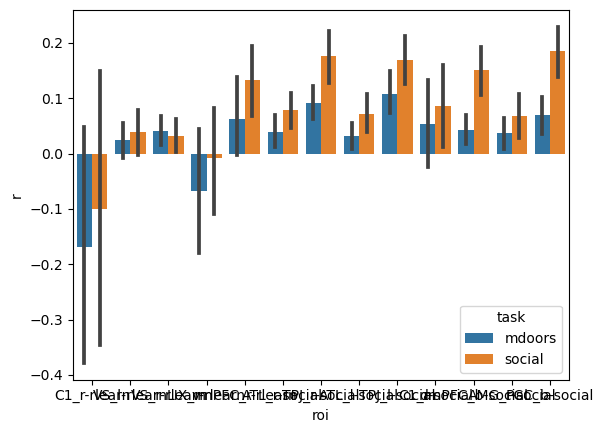

In [24]:
sns.barplot(x='roi',y='r',hue='task', data=all_sub_sim_val_win)
#sns.stripplot(x='roi',y='r',hue='task', data=all_sub_sim_val_win)


In [25]:
#all_sub_sim_val_win.to_csv(outp_dir+'/valence_win_similarity.csv', index=False)
all_sub_val_rsa.to_csv(outp_dir+'/valence_rdm_similarity.csv', index=False)
all_sub_cor_rsa.to_csv(outp_dir+'/correct_rdm_similarity.csv', index=False)
all_sub_cex_rsa.to_csv(outp_dir+'/crctexc_rdm_similarity.csv', index=False)


# ROI to ROI RSA

In [26]:
target_roi_dict = {'C1_r-rlearn':rlearn_roi_dict['C1_r'], 'LIX_r-rlearn':rlearn_roi_dict['LIX_r'],
                   'C1_r-social':social_roi_dict['C1_r']}

target_roi_dict

{'C1_r-rlearn': '/data/projects/social_doors/derivatives/rois/roi_bin_reinforcement-learning_C1_r.nii.gz',
 'LIX_r-rlearn': '/data/projects/social_doors/derivatives/rois/roi_bin_reinforcement-learning_LIX_r.nii.gz',
 'C1_r-social': '/data/projects/social_doors/derivatives/rois/roi_bin_social_C1_r.nii.gz'}

In [27]:
target_roi_names = ['C1_r-rlearn', 'LIX_r-rlearn', 'C1_r-social']
target_roi_paths = {'C1_r-rlearn':rlearn_roi_dict['C1_r'], 'LIX_r-rlearn':rlearn_roi_dict['LIX_r'],
                    'C1_r-social':social_roi_dict['C1_r']}

target_roi_data = {}
for n in range(len(target_roi_names)):
    target_roi_data[target_roi_names[n]] = pd.DataFrame(columns=['subj','group','task','roi','r'])


rois = list(rlearn_roi_dict.values()) + list(social_roi_dict.values())
roi_names = [x + '-rlearn' for x in rlearn_roi_names] + [x + '-social' for x in social_roi_names]

for subj in subjs_list:
    file_list = glob.glob(os.path.join(data_dir, subj, f'tmap*.nii.gz'))
    file_list.sort()
    
    group_id = subjs_scan_info[subjs_scan_info['participant_id'] == subj]['group'].iloc[0]
    
    print('Calculating similarities for '+subj)
    
    for task in ['mdoors', 'social']:
        subj_t1 = bids_dir+"derivatives/fmriprep/"+subj+"/func/"+subj+"_task-"+task+"_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"

        func_files = [x for x in file_list if 'tmap_'+task in x]
        func_files = [x for x in func_files if 'V' not in x]
        func_files.sort()

        if len(func_files) < 6:
            continue
        else:

            betas = Brain_Data(func_files, mask=subj_t1)
            
            for n_targ in range(len(target_roi_data)):
                targ_name = target_roi_names[n_targ]
                targ_mask = Brain_Data(target_roi_paths[targ_name], mask=subj_t1)

                if betas.apply_mask(targ_mask).data.shape[1] == 0:
                    continue
                else:
                    sub_pattern_targ = betas.apply_mask(targ_mask).distance(metric='correlation')
                    sub_pattern_targ.labels = conditions

                    for n in range(len(rois)):
                        temp_mask = Brain_Data(rois[n], mask=subj_t1)

                        if betas.apply_mask(temp_mask).data.shape[1] == 0:
                            continue
                        else:

                            sub_pattern_sim = betas.apply_mask(temp_mask).distance(metric='correlation')
                            sub_pattern_sim.labels = conditions


                            s_targ = sub_pattern_sim.similarity(sub_pattern_targ, metric='spearman', n_permute=0)
                            


                            #all_sub_sim[subj] = s_hyp1['correlation']
                            target_roi_data[targ_name] = target_roi_data[targ_name].append({'subj':subj,
                                                                                           'group':group_id,
                                                                                           'task':task,
                                                                                           'roi':roi_names[n],
                                                                                           'r':s_targ['correlation']},
                                                                                           ignore_index=True)

Calculating similarities for sub-010
Calculating similarities for sub-013
Calculating similarities for sub-028
Calculating similarities for sub-036
Calculating similarities for sub-3845
Calculating similarities for sub-3846
Calculating similarities for sub-3848
Calculating similarities for sub-3849
Calculating similarities for sub-3852
Calculating similarities for sub-3855
Calculating similarities for sub-3864
Calculating similarities for sub-3865
Calculating similarities for sub-3874
Calculating similarities for sub-3880
Calculating similarities for sub-3883
Calculating similarities for sub-3886
Calculating similarities for sub-3887
Calculating similarities for sub-3890
Calculating similarities for sub-3892
Calculating similarities for sub-3893
Calculating similarities for sub-3895
Calculating similarities for sub-3912
Calculating similarities for sub-3920
Calculating similarities for sub-3967
Calculating similarities for sub-3989
Calculating similarities for sub-4011
Calculating simi

In [28]:
for n in range(len(target_roi_data)):
    target_roi_data[target_roi_names[n]].to_csv(outp_dir+'/roi_'+target_roi_names[n]+'_similarity.csv', 
                                                index=False)